<a href="https://colab.research.google.com/github/D34dP0oL/4216_Biomedical_DS_and_AI/blob/main/Sheet6/Assignment6_Solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import numpy as np
import math
import pandas as pd
import random as rand

import scipy.sparse as sparse
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error, classification_report

In [5]:
!pip install nimfa

     |████████████████████████████████| 4.7MB 11.5MB/s 


In [6]:
import nimfa

In [3]:
def get_dataset_from_github(filename, index_col_str=None):    
    data_file_path = "https://raw.githubusercontent.com/D34dP0oL/4216_Biomedical_DS_and_AI/main/Datasets/"
    if index_col_str is None:
        data = pd.read_csv(data_file_path + filename)
    else:
        data = pd.read_csv(data_file_path + filename, index_col=index_col_str)

    return data

## Biomedical Data Science & AI

## Assignment 6

#### Group members:  Fabrice Beaumont, Fatemeh Salehi, Genivika Mann, Helia Salimi, Jonah

---
### Exercise 1 - NMF clustering


#### 1.1. Write an algorithm to showcase the working of Non-negative matrix factorization (NMF).

**Input:** Non-negative matrix $X_{n\times m}$ (where n represents features and m represents data point) and factorization rank $k$ (selected such that $(n+m)r<nm$)


**Output:** Non-negative matrices $W_{n\times k}$ and $H_{k\times m}$

**Objective:** Minimise the below objective function by alternating minimizations of $W$ and $H$:
$$D(X||WH) = \sum_{ij}\left( x_{ij}\log\frac{x_{ij}}{w_{ij}H_{ij}}-x_{ij}+w_{ij}\right)$$

**Algorithm**:
1. Generate initial non-negative matrices $W^{0}$ and $H^{0}$ using an initialization algorithm(eg. random initialization).
2. Loop from $t=0$ until $W^{t-1} = W^{t},H^{t-1} = H^{t}$(i.e W and H converge) or until $t==$ max. iterations
    1. Update elements of the matrix $W^{t}$.
        $$
        w_{ik}= w_{ik} \frac{\frac{\sum_{j=1}^{p}h_{kj}x_{ij}}{(WH)_{ij}}}{\sum_{j=1}^{p}h_{kj}}
        $$
    2. Update elements of the matrix $H^{t}$.
        $$
        h_{kj}= h_{kj} \frac{\frac{\sum_{i=1}^{N}w_{ik}x_{ij}}{(WH)_{ij}}}{\sum_{i=1}^{N}w_{ik}}
        $$
3. end loop



#### 1.2. Mention the pros and cons of NMF as well as one of its applications.

**Advantages of NMF:**
- It is useful for **high dimensional data** as it extracts **sparse and meaningful features** from non-negative data vectors.
- It is a **biclustering** algorithm as it performs both **feature selection** and **clustering**. The sparse NMF enforces sparsity on the factor matrices which results in identification of sparse set of features specific for each cluster in the factor matrices.
- It is **not distance based**.

**Disadvantages of NMF:**
- It can only detect **linearly separable clusters**.
- It is **computationally demanding**.
- The procedure is prone to **random initialization**. Hence we may get different clusters depending on initialization. This problem can be tackled by performing NMF multiple times and analysing the consensus matrix.

**Applications:**
1. **Text Mining** - NMF can be used for text mining in areas such as topic modeling, document clustering, topic detection and trend tracking, email analysis.
2. **Image Analysis and Computer Vision** - NMF is also applied in feature representation for facial feature extraction and video tracking. 

#### 1.3. Use the nimfa package for NMF clustering on the `gene expression data` to cluster genes into groups. Use the parameters (10 ranks, 50 maximum iterations and 25 runs) to compute the following:

In [7]:
# load the dataset
gene_expression_data = get_dataset_from_github("allData.csv", index_col_str="Unnamed: 0")

# Dataset contains data for 5000 genes and 128 patients
gene_expression_data

,36638_at,39318_at,38514_at,266_s_at,38585_at,41266_at,36108_at,39389_at,31525_s_at,32612_at,36536_at,40202_at,33705_at,33516_at,33412_at,41166_at,32649_at,37006_at,33809_at,1065_at,37701_at,39729_at,40570_at,37043_at,36878_f_at,32035_at,38968_at,307_at,36773_f_at,41165_g_at,296_at,34033_s_at,38242_at,37399_at,41723_s_at,35926_s_at,41164_at,36239_at,34362_at,40775_at,...,35701_at,37888_at,40272_at,1202_g_at,38136_at,38434_at,32327_at,40455_at,1823_g_at,39119_s_at,35828_at,35566_f_at,32180_s_at,40418_at,40262_at,41607_at,394_at,32038_s_at,35677_at,38139_at,32472_at,40077_at,846_s_at,35883_at,31568_at,31880_at,35878_at,34689_at,41060_at,38198_at,37655_at,1440_s_at,32260_at,40070_at,1056_s_at,39200_s_at,36105_at,32578_at,39383_at,33718_at
01005,0.583368,0.535258,0.642984,0.891901,0.269871,0.605566,0.069070,0.938101,0.314737,0.590410,0.796561,0.850594,0.918978,0.240408,0.414888,0.691153,0.411294,0.637927,0.594209,0.518397,0.670180,0.332630,0.840712,0.631080,0.473505,0.851113,0.545758,0.457605,0.462939,0.868577,0.330381,0.801885,0.712293,0.134634,0.791588,0.787409,0.991021,0.543582,0.732365,0.176654,...,0.378084,0.483172,0.168982,0.330266,0.419703,0.571903,0.580894,0.234959,0.718483,0.114381,0.267416,0.144547,0.391687,0.348717,0.551471,0.410498,0.364310,0.407837,0.294238,0.237388,0.224433,0.200875,0.318495,0.124299,0.678597,0.353297,0.230118,0.438577,0.464230,0.337547,0.884590,0.399443,0.379796,0.272379,0.216088,0.355740,0.167203,0.438651,0.395720,0.273593
01010,0.505321,0.704177,0.913612,0.657634,0.402911,0.429698,0.803187,0.360471,0.718665,0.773198,0.346023,0.439240,0.575085,0.333801,0.267722,0.717744,0.164642,0.917898,0.095272,0.252275,0.123748,0.465028,0.534974,0.208745,0.748863,0.370238,0.785184,0.561516,0.752276,0.722854,0.224205,0.486049,0.578132,0.073096,0.969421,0.121779,0.639100,0.714173,0.301113,0.218048,...,0.801471,0.399995,0.444195,0.308787,0.128357,0.814556,0.308978,0.276849,0.583248,0.534276,0.540936,0.278203,0.397564,0.209693,0.316325,0.078122,0.366716,0.377046,0.226715,0.237455,0.328624,0.294165,0.441081,0.559321,0.691367,0.297660,0.406114,0.850692,0.225666,0.208741,0.086277,0.432789,0.431440,0.461242,0.443493,0.291054,0.102883,0.584035,0.589994,0.401375
03002,0.375805,0.073716,0.707562,0.847162,0.792428,0.819212,0.644334,0.735292,0.828776,0.821131,0.694593,0.912418,0.925177,0.604762,0.845645,0.102832,0.441828,0.960942,0.822917,0.579433,0.574525,0.209021,0.661056,0.446048,0.711056,0.422506,0.933707,0.548291,0.714249,0.260367,0.282758,0.977896,0.804228,0.809919,0.875175,0.835892,0.395444,0.679245,0.587615,0.268066,...,0.333469,0.406121,0.116223,0.227236,0.230363,0.476691,0.638118,0.138736,0.465002,0.177763,0.594686,0.107521,0.554402,0.391740,0.279571,0.297585,0.246278,0.163830,0.349512,0.319535,0.237265,0.570321,0.201130,0.137217,0.659292,0.323094,0.426197,0.176555,0.253732,0.405952,0.750758,0.305592,0.444996,0.293573,0.318939,0.259713,0.271869,0.556874,0.931118,0.301529
04006,1.000000,0.226960,0.119596,0.394317,0.115411,0.050117,0.440698,0.649291,0.498758,0.692290,0.087991,0.757562,0.264205,0.178758,1.000000,0.630364,0.023287,0.051236,0.037160,0.553999,0.181132,0.402491,0.379906,0.139041,0.481713,0.206804,0.526957,0.222823,0.431150,0.722786,0.562790,0.676347,0.385088,0.445281,0.772617,0.686851,0.719016,0.044023,0.266791,0.149898,...,0.820746,0.479706,0.209392,0.283426,0.224231,0.826304,0.036298,0.199957,0.851421,0.203652,0.542015,0.223738,0.000000,0.210257,0.510002,0.088128,0.628238,0.430658,0.274953,0.062263,0.217099,0.519138,0.394596,0.253829,0.846699,0.030612,0.160331,0.723064,0.393538,0.194421,0.090901,0.365967,0.170796,0.565408,0.456499,0.407845,0.100038,0.670769,0.541601,0.659517
04007,0.890125,0.631314,0.518785,0.880312,1.000000,0.858408,0.638519,0.933899,0.963169,0.818224,0.535331,0.898372,0.926657,0.846969,0.170609,0.704562,0.252964,0.840893,0.918630,0.764969,0.333374,0.765046,0.909528,0.933666,0.808702,0.976422,0.873553,0.577796,0.755567,0.802039,0.427700,0.804084,0.760240,0.489169,0.881994,0.287268,0.91

In [8]:
# transpose the matrix so that gene expression features are present along row and patient samples
# are present along column, since NMF algorithms require features to be present along rows and
# samples present along columns
gene_expression_data = gene_expression_data.T
gene_expression_data

,01005,01010,03002,04006,04007,04008,04010,04016,06002,08001,08011,08012,08018,08024,09008,09017,11005,12006,12007,12012,12019,12026,14016,15001,15004,15005,16004,16009,19005,20002,22009,22010,22011,22013,24001,24005,24008,24010,24011,24017,...,64001,64002,65005,68001,68003,84004,LAL5,01003,01007,02020,04018,09002,10005,11002,12008,15006,16002,16007,17003,18001,19002,19008,19014,19017,20005,24006,26009,28008,28009,31015,37001,43006,43015,44001,49004,56007,64005,65003,83001,LAL4
36638_at,0.583368,0.505321,0.375805,1.000000,0.890125,0.015269,0.198995,0.262746,0.000000,0.806019,0.692559,0.277515,0.322394,0.375715,0.684558,0.752682,0.722361,0.718326,0.756068,0.659369,0.569807,0.388773,0.695404,0.353944,0.897458,0.698388,0.682201,0.088996,0.798552,0.306779,0.267395,0.067844,0.409219,0.802846,0.578941,0.908053,0.324830,0.781241,0.803168,0.394646,...,0.681933,0.178811,0.745151,0.126567,0.709436,0.887262,0.432983,0.097948,0.108993,0.080268,0.043897,0.079175,0.182502,0.142439,0.101625,0.033591,0.058946,0.062742,0.084656,0.145296,0.008051,0.122108,0.034378,0.108406,0.132328,0.070793,0.073178,0.096580,0.072055,0.084068,0.027652,0.068056,0.007161,0.122048,0.092802,0.072759,0.053972,0.136163,0.022913,0.060686
39318_at,0.535258,0.704177,0.073716,0.226960,0.631314,0.200666,0.838839,0.182013,0.128862,0.530119,0.677224,0.640806,0.663941,0.258496,0.891362,0.641042,0.708184,0.653712,0.385693,0.013329,0.513790,0.253276,0.065792,0.511977,0.205911,0.726466,0.170650,0.482767,0.266564,0.166389,0.291895,0.506378,0.201323,0.097011,0.507479,0.338769,0.521623,0.648001,0.497395,0.210510,...,0.657223,0.502717,0.311046,0.426952,0.427635,0.014288,0.676291,0.031417,0.016688,0.088286,0.043172,0.076267,0.007593,0.080682,0.095095,0.072924,0.001821,0.007816,0.102957,0.035593,0.075475,0.064498,0.091034,0.084101,0.053690,0.088813,0.131927,0.032501,0.047843,0.088048,0.062598,0.000000,0.084411,0.105926,0.016825,0.068235,0.086147,0.082575,0.026321,0.091866
38514_at,0.642984,0.913612,0.707562,0.119596,0.518785,0.499243,0.961742,0.564457,0.414330,0.193236,0.524249,0.775625,0.667670,0.018227,0.774230,0.510303,0.537349,0.055171,0.428153,0.261719,0.592253,0.032013,0.175034,0.233551,0.491460,0.464333,0.458282,0.584649,0.526413,0.789192,0.381525,0.127308,0.042941,0.332039,0.698663,0.573582,0.222438,0.342756,0.630626,0.074464,...,0.364441,0.896267,0.313433,0.890112,0.083992,0.350499,0.642825,0.086817,0.601450,0.554403,0.282904,0.096552,0.501360,0.500465,0.170396,0.599786,0.229882,0.320748,0.834142,0.840381,0.321355,0.488987,0.802427,0.091139,0.787187,0.089560,0.451128,0.507536,0.535121,0.599800,0.028387,0.032067,0.475572,0.137729,0.174771,0.473041,0.000065,0.456977,0.774337,0.710210
266_s_at,0.891901,0.657634,0.847162,0.394317,0.880312,0.765667,0.947758,0.691745,0.764316,0.848112,0.931445,0.837018,0.634944,0.328985,0.919713,0.840403,0.921656,0.895931,0.800624,0.451617,0.735399,0.609946,0.268450,0.775320,0.387596,0.802828,0.371029,0.427131,0.172877,0.379312,0.209994,0.563751,0.734015,0.502308,0.661838,0.319607,0.713253,0.836141,0.783192,0.685724,...,0.641136,0.408060,0.523368,0.341189,0.877377,0.512372,0.719037,0.280221,0.171660,0.120613,0.098869,0.478389,0.235160,0.244276,0.150481,0.166987,0.185296,0.020562,0.130338,0.020408,0.456283,0.116035,0.102212,0.075708,0.000000,0.095787,0.158506,0.163375,0.167522,0.211806,0.121269,0.207306,0.314549,0.394670,0.229842,0.239455,0.136057,0.120866,0.135344,0.218240
38585_at,0.269871,0.402911,0.792428,0.115411,1.000000,0.403957,0.260541,0.713319,0.750092,0.353165,0.095036,0.024041,0.622681,0.175910,0.239634,0.564297,0.548094,0.048539,0.788259,0.291601,0.443195,0.946321,0.956737,0.209176,0.618209,0.108677,0.605644,0.736659,0.802742,0.037726,0.727876,0.271039,0.305344,0.735877,0.388003,0.836970,0.803727,0.272098,0.813894,0.654390,...,0.285994,0.245625,0.404926,0.612250,0.122006,0.345858,0.322056,0.424453,0.354174,0.646146,0.072779,0.630974,0.117645,0.077487,0.486139,0.160903,0.794243,0.831392,0.095197,0.025745,0.148109,0.193980,0.388347,0.166

In [16]:
# creating Standard NMF model for data with 10 ranks, 50 maximum iterations and 25 runs
nmf_model = nimfa.Nmf(
    V = gene_expression_data.to_numpy(), # target matrix, we convert dataframe to matrix
    rank = 10, # factorization rank
    max_iter = 50, # max factorization iterations
    n_run = 25, # runs of the algorithm
    track_factor=True, # enable track_factor to compute connectivity matrix across multiple runs
)

# instantiate model
nmf_fit = nmf_model()

# model summary
# print(nmf_fit.summary())

#### 1.3.a) From the average connectivity matrix across multiple runs compute consensus matrix.

In [11]:
# consensus matrix
print( 'Consensus Matrix')
consensus_matrix = nmf_fit.summary()['consensus']
consensus_matrix

Consensus Matrix


matrix([[1.0000000e+00, 8.8817842e-18, 5.6000000e-01, ..., 8.8817842e-18,
         8.8817842e-18, 8.8817842e-18],
        [8.8817842e-18, 1.0000000e+00, 8.8817842e-18, ..., 8.8817842e-18,
         4.0000000e-02, 8.8817842e-18],
        [5.6000000e-01, 8.8817842e-18, 1.0000000e+00, ..., 8.8817842e-18,
         8.8817842e-18, 8.8817842e-18],
        ...,
        [8.8817842e-18, 8.8817842e-18, 8.8817842e-18, ..., 1.0000000e+00,
         2.0000000e-01, 6.4000000e-01],
        [8.8817842e-18, 4.0000000e-02, 8.8817842e-18, ..., 2.0000000e-01,
         1.0000000e+00, 1.6000000e-01],
        [8.8817842e-18, 8.8817842e-18, 8.8817842e-18, ..., 6.4000000e-01,
         1.6000000e-01, 1.0000000e+00]])

#### 1.3.b) Produce a heatmap with a dendrogram from the clustering results you obtained.

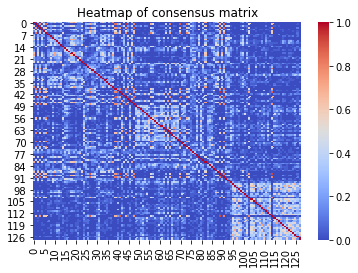

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


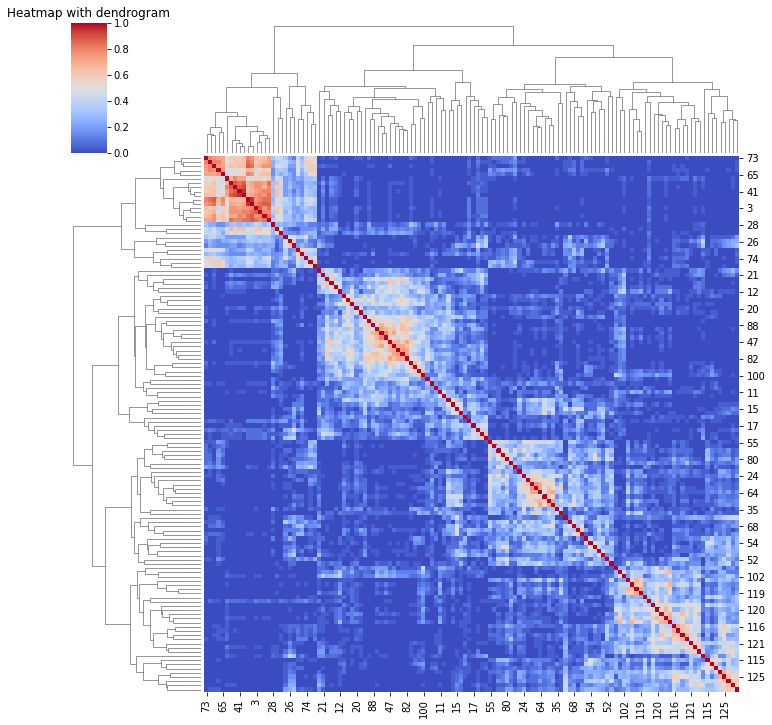

In [14]:
# heatmap of consensus matrix
plt.title('Heatmap of consensus matrix')
sns.heatmap(consensus_matrix, cmap='coolwarm')
plt.show()
# heatmap with dendrogram
sns.clustermap(consensus_matrix, cmap='coolwarm')
plt.title('Heatmap with dendrogram')
plt.show()

#### 1.3.c) What are the consequences of selecting a rank value that is too small or too large? Implement a method showing how you can optimize the value of the rank to be used.

The rank indicates the no. of clusters into which the data will be divided. It defines the size of the new subspace i.e the no. of features to be extracted. If **rank is too low we will miss features** and **if rank is too large we will model noise**. Hence its important to pick an optimal rank which reduces the noise in the data and effectively models the features.

We can optimise the value of rank by running the NMF algorithm on data and measuring the quality of clustering based on different quality metrics. The rank corresponding to the best quality clustering can then be selected.

In [15]:
# method to find the optimum rank value using cophenetic correlation coefficient
def get_optimum_rank(candidate_ranks = [8, 10], data = None, quality_metric = 'cophenetic'):
    '''
    This method selects the optimum rank value from the
    list of candidate ranks. The optimum rank value is the rank which
    produces a clustering having the highest value of the quality metric.
    
    Parameters:
    candidate_ranks -  The list of candidate ranks which will be tested to find the optimum rank,
    data - The data to be clustered,
    quality_metric - The metric used to asses the quality of the clustering produced by the rank.
    We assess the quality of the clustering using cophenetic correlation 
    '''
    
    # initialise best_rank and quality metric result
    best_rank = candidate_ranks[0]
    quality_metric_results = []
    
    # iterate over all candidate ranks
    for candidate_rank in candidate_ranks:
        
        # perform NMF clustering with candidate rank
        nmf_model = nimfa.Nmf(
            V = data.to_numpy(),
            rank = candidate_rank,
            max_iter = 50,
            n_run = 35,
            track_factor=True,
        )
        nmf_fit = nmf_model()
        
        # choose highest rank before cophenetic correlation starts dropping
        if( 0 < len(quality_metric_results) and quality_metric_results[- 1] > nmf_fit.summary()['cophenetic'] ):
            break
        else:
            best_rank = candidate_rank
            
        quality_metric_results.append(nmf_fit.summary()['cophenetic'])
        
    return best_rank
    
print( 'Optimum rank ', get_optimum_rank(candidate_ranks = [2, 3, 10], data = gene_expression_data))   

Optimum rank  3


#### 1.4. Inform yourself about **Non-Negative Matrix Tri-Factorization** (**NMTF**). What is the primary difference between NMF and NMTF and what does it achieve?

#### 1.5. PCA and NMF are both matrix factorization methods, how do they differ from each other? Describe a situation where PCA is favored over NMF.

Description of PCA: ...
Description of NMF: ...

Differences:
- ...

Situation where PCA is favored over NMF:

---
### Exercise 2 - Machine Learning

#### 2.1. The type of machine learning (e.g. supervised learning, unsupervised learning, etc.) applied depends on the problem at hand. Assume that we have an `Alzheimer's disease (AD) dataset` where rows represent 500 participants and columns represent 100 different collected measurements for each participant.

##### 2.1.a) You are asked to train a model that can predict whether a participant is healthy or AD. Mention the type of machine learning you would use for this case scenario and elaborate.

We would use **supervised learning** because in this dataset we are dealing with labeled samples that we can use to learn how to correctly classify unseen participants. We have a very small amount of data at hand and so it is important that we choose a low-complexity model to not overfit the given data.We are also not interested in the different clusters into which the patients or features can be divided based on the data hence unsupervised learning does not seem appropriate.

##### 2.1.b) Assume that we do not have any information about the diagnosis of each participant. This time we would like to divide our participants into groups based on the features that we have in hand. What type of machine learning would be appropriate for this scenario and elaborate?

In this case we can't use supervised learning as our samples are not labeled, so we would choose **unsupervised learning** ( eg. hierarchical clustering, k-means clustering, GMMs, NMF). Our goal then is to learn the inherent structure of our samples and find clusters that could then be used to categorize new samples.

##### 2.1.c) Imagine that the shape of our dataset is *(100, 600)*, mention one pre-processing step that you would take to carry out the tasks *2.1.a)* and *2.1.b)*?

The shape of our dataset indicates that we have 100 samples and 600 features. The no. of features in the dataset is very large as compared to samples. To deal with this high dimensional data, we can apply dimensionality reduction technique of Principal Component Analysis as a pre-processing step. We can then select the no. of Principal Components to represent our data and apply machine learning tasks (a) and (b) on the selected Principal Components.

2.1.a) We would slice the dataset into two distinct sets, namely a training and a test set. The training set is used to train the supervised learning algorithm we're using. The test set is then used to evaluate the model and is used once the model is trained. We would split the dataset at 500 participants so that we have a training set of size (100, 500) and a test set of size (100, 100).

2.1.b) For unsupervised learning in this case we do not need to split the set into training and test set as we want to find the inherent structure of the given data and so it is crucial to have as much data at hand as possible. Also we wouldn't be able to evaluate the model with a test set because there is no way to evaluate the performance without given labels.

#### 2.2. Generate a pipeline in scikit learn using the following code snippet:

In [17]:
####################### Given Code Snippet ############################
# polynomial_features = PolynomialFeatures(degree=15, include_bias=False)
# linear_regression = LinearRegression()

# pipeline = Pipeline([
#     ("polynomial_features", polynomial_features),
#     ("linear_regression", linear_regression)
# ])`
#######################################################################

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

polynomial_features = PolynomialFeatures(degree=15, include_bias=False)
linear_regression = LinearRegression()

pipeline = Pipeline([
  ("polynomial_features", polynomial_features),
  ("linear_regression", linear_regression)
])

##### 2.2.a) Using the Fish dataset provided, identify the quality of fit of the pipeline for the dataset (use the weight as the response variable).

In [18]:
fish_ds = get_dataset_from_github("Fish.csv")
fish_ds.head(4)

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555


In [23]:
from sklearn.model_selection import train_test_split

y = fish_ds['Weight'].to_numpy()
X = fish_ds.drop(['Weight'], axis=1).to_numpy()
# replace the species strings with numbers. Should we do this? seems wrong to me as its categorical
# However, we will have to do this to handle the categorical feature "Species" before the data is fed into pipeline
_, X[:,0] = np.unique(X[:,0], return_inverse=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipeline.fit(X_train, y_train)
y_predicted = pipeline.predict(X_test)

print( f"Score: {pipeline.score(X_test, y_test)}")
print(f'Explained Variance: {explained_variance_score(y_test, y_predicted)}')
print(f'Mean Absolute Error: {mean_absolute_error(y_test, y_predicted)}')
print(f'R2 Score: {r2_score(y_test, y_predicted)}')
print(f'Mean Squared Error: {mean_squared_error(y_test, y_predicted)}')

Score: -47656136990019.97
Explained Variance: -45695382578656.23
Mean Absolute Error: 734433808.8446305
R2 Score: -47656136990019.97
Mean Squared Error: 9.053322170016345e+18


##### 2.2.b) If the pipeline produces a badly fit model for the dataset, list some methods to improve the model.

The model has been a bad fit as indicated by explained variance score, mean absolute error, R^2 score and mean squared error.


Methods to improve the model:
- Remove the Polynomial Features preprocessing step from pipeline
- Perform PCA to decorrelate features
- Use regularization techniques and perform Lasso or Ridge Regression

#### 2.3. In this exercise we will compare the accuracy of different methods on a high-dimensional ($p>>n$) dataset. Load the leukemia_small.csv and extract the class labels from the column names (2 classes, `AML` and `ALL`).Randomly split the data into *70%* training and *30%* test.

**Hint:** Use the `train_test_split` function from scikit-learn to define the test_size and
set `random_state=1` for better reproducibility.


##### 2.3.a) Fit a logistic regression (no penalization)

##### 2.3.b) Fit multiple $l_1$-penalized logistic regressions ($\lambda \in \{ 0.001,\ 0.01,\  0.1,\ 
1,\  10,\ 100\}$)

##### 2.3.c) Fit multiple $l_2$-penalized logistic regressions ($\lambda \in \{ 0.001,\ 0.01,\  0.1,\ 
1,\  10,\ 100\}$)

##### 2.3.d) For the models from *2.3.a)*, *2.3.b)*, and *2.3.c)* measure the performance on the training and test set

##### 2.3.e) Using *2.3.d)* report the performances with one scatterplot for each approach (one scatterplot for each: unpenalized, $l_1$, $l_2$), with the regularization constant on the $x$-axis and the accuracy on the $y$-axis, train and test set colored differently, proper axis labels and a legend.

##### 2.3.f) Which method in combination with which parameter gives the best results on the test set?